# Progetto per tesi

Installazione libreria MediaPipe e download del modello da utilizzare per estrarre i keypoints dall'immagine.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

!pip install -q tensorflow
!pip install -q mediapipe==0.10.0
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 29.2 MB/s eta 0:00:00


## Setup del modello di pose estimation




In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.tasks.python.vision.core.vision_task_running_mode import VisionTaskRunningMode
import cv2
from google.colab.patches import cv2_imshow
import os

input_folder = '/content/drive/MyDrive/Colab Notebooks/TESI/dataset/dataset_img_2'

output_folder = '/content/drive/MyDrive/Colab Notebooks/TESI/dataset/dataset_landmarks'

base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')

options = vision.PoseLandmarkerOptions(
    base_options = base_options,
    running_mode = VisionTaskRunningMode.IMAGE,
    num_poses = 1,
    min_pose_detection_confidence = 0.5,
    min_pose_presence_confidence = 0.5,
    min_tracking_confidence = 0.5,
    output_segmentation_masks = False
)

detector = vision.PoseLandmarker.create_from_options(options)

significant_indexes = [7,8,11,12,13,14,15,16,23,24,25,26,27,28,31,32]

'''
7 - left ear
8 - right ear
11 - left shoulder
12 - right shoulder
13 - left elbow
14 - right elbow
15 - left wrist
16 - right wrist
23 - left hip
24 - right hip
25 - left knee
26 - right knee
27 - left ankle
28 - right ankle
31 - left foot index
32 - right foot index
'''

'\n7 - left ear\n8 - right ear\n11 - left shoulder\n12 - right shoulder\n13 - left elbow\n14 - right elbow\n15 - left wrist\n16 - right wrist\n23 - left hip\n24 - right hip\n25 - left knee\n26 - right knee\n27 - left ankle\n28 - right ankle\n31 - left foot index\n32 - right foot index\n'

## Creazione del dataset

Estrazione e salvataggio delle coordinate corrispondenti alle pose identificate dalle immagini del dataset.

In [ ]:
''' TODO: prima di runnare eliminare la cartella già presente su drive
def extract_and_save_keypoints(img_path, output_path):
  img = mp.Image.create_from_file(img_path)
  detection_result = detector.detect(img)
  if(len(detection_result.pose_landmarks) > 0) :
    pose_landmarks = detection_result.pose_landmarks[0]

    with open(output_path, 'w') as f:
      for i, pl in enumerate(pose_landmarks):
        f.write(f"{pose_landmarks[i].x},{pose_landmarks[i].y}\n")

for i, label in enumerate(os.listdir(input_folder)):
    label_folder = os.path.join(input_folder, label)
    output_label_folder = os.path.join(output_folder, str(i))

    os.makedirs(output_label_folder, exist_ok=True)

    for img_name in os.listdir(label_folder):
        img_path = os.path.join(label_folder, img_name)
        output_path = os.path.join(output_label_folder, f"{os.path.splitext(img_name)[0]}.txt")
        print(img_path, output_path)

        extract_and_save_keypoints(img_path, output_path)
'''

## Architettura di rete

Caricamento del dataset e definizione del modello

In [ ]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

def load_dataset():
    x = []
    y = []

    for label in os.listdir(output_folder):
        label_folder_landmarks = os.path.join(output_folder, label)

        for txt_name in os.listdir(label_folder_landmarks):
            landmarks_file_path = os.path.join(label_folder_landmarks, txt_name)
            with open(landmarks_file_path, 'r') as f:
              landmarks = []
              for i, line in enumerate(f):
                if(i in significant_indexes):
                  coordinates = list(map(float, line.strip().split(',')))[:3]
                  landmarks.append(coordinates)
              landmarks = np.array(landmarks)
              x.append(landmarks)
              y.append(int(label))

    return np.array(x), np.array(y)

num_classes = 4
num_keypoints = len(significant_indexes)
num_coordinates = 3

x, y = load_dataset()

## Allenamento de modello

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

def split_train_predict(x, y, seed):
  x_train, x_other, y_train, y_other = train_test_split(x, y, test_size = 0.2, random_state = seed)
  x_val, x_test, y_val, y_test = train_test_split(x_other, y_other, test_size = 0.5, random_state = seed)

  model = models.Sequential([
      layers.Flatten(input_shape=(num_keypoints, num_coordinates)),
      layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
      layers.Dense(num_classes, activation='softmax')
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

  model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  # model.summary()

  history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), batch_size=2)

  loss, accuracy = model.evaluate(x_test, y_test)

  print("Loss sul set di test:", loss)
  print("Accuracy sul set di test:", accuracy)

  y_pred = model.predict(x_test)
  y_pred_classes = np.argmax(y_pred, axis=1)

  f1score = f1_score(y_test, y_pred_classes, average='weighted')

  print("F1 score sul set di test", f1score)

  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss durante l\'addestramento e la validazione')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy durante l\'addestramento e la validazione')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  model.save('dense' + str(seed) + '.h5')

  return y_test, y_pred_classes


0 14
Epoch 1/10
112/112 [==============================] - 1s 3ms/step - loss: 1.4538 - accuracy: 0.3661 - val_loss: 1.3185 - val_accuracy: 0.3214
Epoch 2/10
112/112 [==============================] - 0s 2ms/step - loss: 1.2041 - accuracy: 0.5402 - val_loss: 1.1000 - val_accuracy: 0.5714
Epoch 3/10
112/112 [==============================] - 0s 2ms/step - loss: 1.0026 - accuracy: 0.7054 - val_loss: 0.9185 - val_accuracy: 0.6429
Epoch 4/10
112/112 [==============================] - 0s 2ms/step - loss: 0.8528 - accuracy: 0.7500 - val_loss: 0.8299 - val_accuracy: 0.6429
Epoch 5/10
112/112 [==============================] - 0s 2ms/step - loss: 0.7237 - accuracy: 0.8259 - val_loss: 0.6751 - val_accuracy: 0.8214
Epoch 6/10
112/112 [==============================] - 0s 2ms/step - loss: 0.6061 - accuracy: 0.9509 - val_loss: 0.5910 - val_accuracy: 0.8571
Epoch 7/10
112/112 [==============================] - 0s 2ms/step - loss: 0.5232 - accuracy: 0.9554 - val_loss: 0.5497 - val_accuracy: 0.8571
E

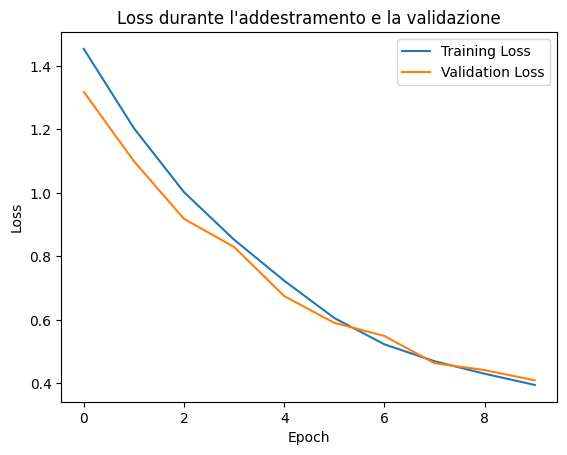

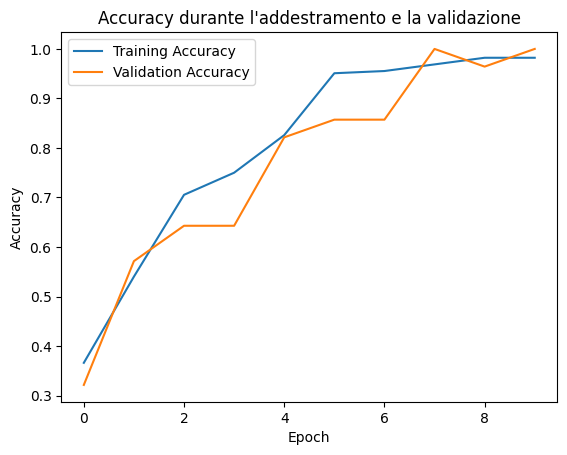

1 21
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 1s 3ms/step - loss: 1.4478 - accuracy: 0.4375 - val_loss: 1.3849 - val_accuracy: 0.2857
Epoch 2/10
112/112 [==============================] - 0s 2ms/step - loss: 1.2671 - accuracy: 0.4509 - val_loss: 1.2236 - val_accuracy: 0.4286
Epoch 3/10
112/112 [==============================] - 0s 2ms/step - loss: 1.1223 - accuracy: 0.5179 - val_loss: 1.1017 - val_accuracy: 0.5714
Epoch 4/10
112/112 [==============================] - 0s 2ms/step - loss: 1.0225 - accuracy: 0.5759 - val_loss: 1.0109 - val_accuracy: 0.6071
Epoch 5/10
112/112 [==============================] - 0s 3ms/step - loss: 0.9446 - accuracy: 0.5893 - val_loss: 0.9473 - val_accuracy: 0.6429
Epoch 6/10
112/112 [==============================] - 0s 3ms/step - loss: 0.8771 - accuracy: 0.7009 - val_loss: 0.8875 - val_accuracy: 0.6429
Epoch 7/10
112/112 [==============================] - 0s 3ms/step - loss: 0.8055 - accuracy: 0.7946 - val_loss: 0.8250 - val_accuracy: 0.8214
Epoch 8/10
112/11

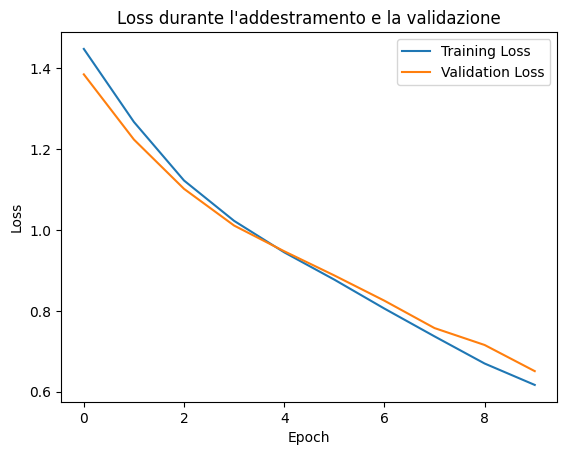

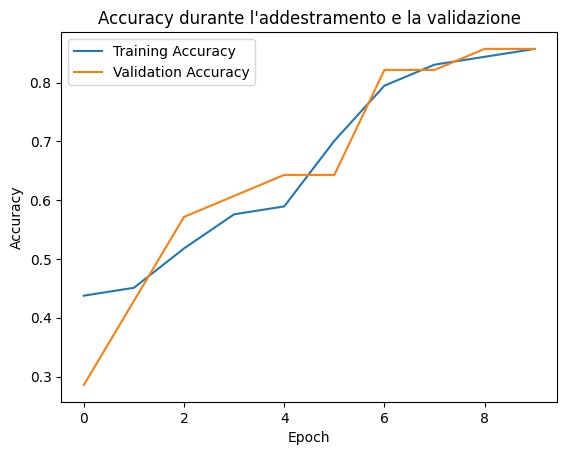

2 42
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 1s 5ms/step - loss: 1.4434 - accuracy: 0.4554 - val_loss: 1.2689 - val_accuracy: 0.7857
Epoch 2/10
112/112 [==============================] - 0s 2ms/step - loss: 1.1687 - accuracy: 0.6875 - val_loss: 1.0224 - val_accuracy: 0.8571
Epoch 3/10
112/112 [==============================] - 0s 2ms/step - loss: 0.9667 - accuracy: 0.7902 - val_loss: 0.8499 - val_accuracy: 0.8929
Epoch 4/10
112/112 [==============================] - 0s 2ms/step - loss: 0.8139 - accuracy: 0.8348 - val_loss: 0.7607 - val_accuracy: 0.7857
Epoch 5/10
112/112 [==============================] - 0s 2ms/step - loss: 0.7092 - accuracy: 0.8438 - val_loss: 0.6478 - val_accuracy: 0.8214
Epoch 6/10
112/112 [==============================] - 0s 2ms/step - loss: 0.6148 - accuracy: 0.8705 - val_loss: 0.5387 - val_accuracy: 0.8929
Epoch 7/10
112/112 [==============================] - 0s 2ms/step - loss: 0.5358 - accuracy: 0.9152 - val_loss: 0.5130 - val_accuracy: 0.9286
Epoch 8/10
112/11

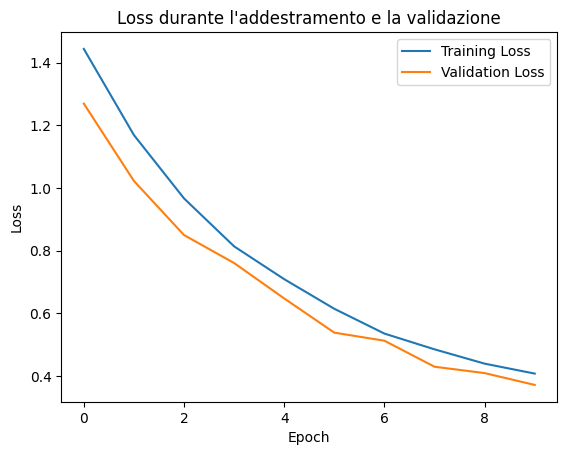

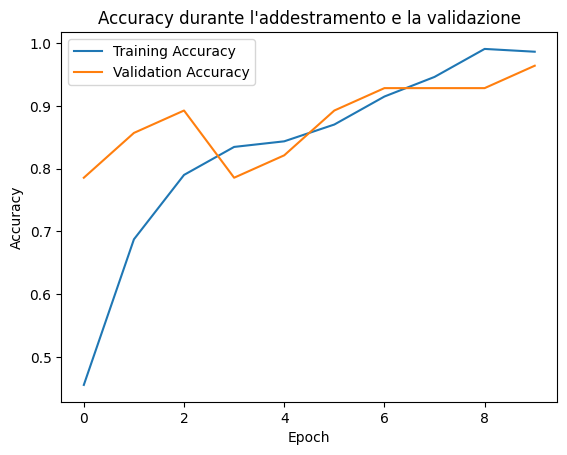

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


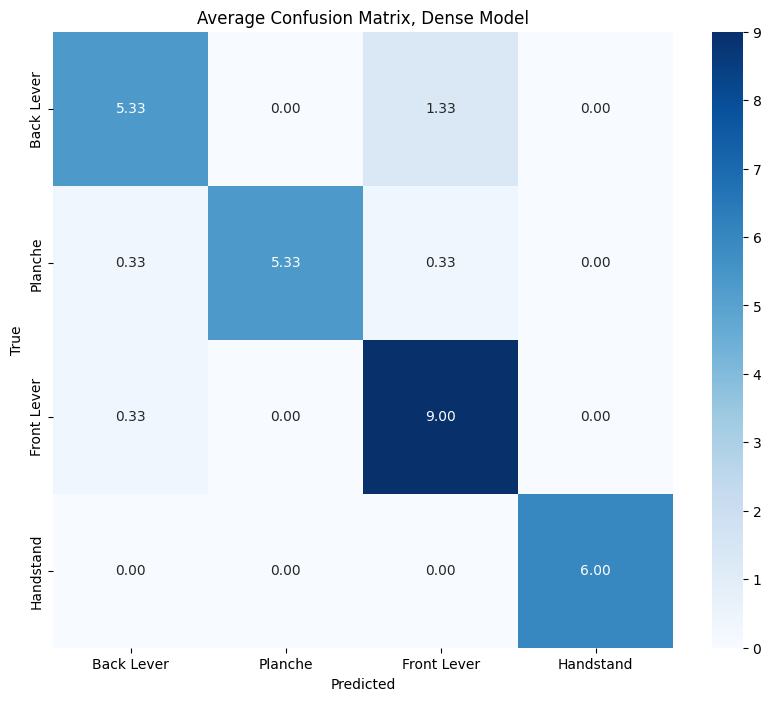

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

runs = [14, 21, 42]
confusion_matrices = []
labels = ['Back Lever', 'Planche', 'Front Lever', 'Handstand']

for i, seed in enumerate(runs):
  print(i, seed)
  y_true, y_pred_classes = split_train_predict(x, y, seed)
  cm = confusion_matrix(y_true, y_pred_classes)
  confusion_matrices.append(cm)

# Calcola la media delle confusion matrix
average_cm = np.mean(confusion_matrices, axis=0)

# Stampa la confusion matrix media
plt.figure(figsize=(10, 8))
sns.heatmap(average_cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Average Confusion Matrix, Dense Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Test del modello sul set di validazione in modo manuale

In [ ]:
from random import randint

seed = 17

x_train, x_other, y_train, y_other = train_test_split(x, y, test_size = 0.2, random_state = seed)
x_val, x_test, y_val, y_test = train_test_split(x_other, y_other, test_size = 0.5, random_state = seed)

model = models.Sequential([
    layers.Flatten(input_shape=(num_keypoints, num_coordinates)),
    layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# model.summary()

history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), batch_size=2)

loss, accuracy = model.evaluate(x_test, y_test)

print("Loss sul set di test:", loss)
print("Accuracy sul set di test:", accuracy)

In [ ]:
labels = ['back_lever', 'planche', 'front_lever', 'handstand']
# random_index = randint(0, len(x_test) - 1)
# random_sample = x_test[random_index].reshape(1, len(significant_indexes), num_coordinates)
# print(random_index)

# prediction = model.predict(random_sample)
# predicted_class = np.argmax(prediction)
# print(prediction, predicted_class)

# print(f"True Label: {labels[y_test[random_index]]}, Predicted Label: {labels[predicted_class]}")

random_index = 22
print(x_test[random_index].reshape(1, len(significant_indexes), num_coordinates))
random_sample = x_test[random_index].reshape(1, len(significant_indexes), num_coordinates)

for label in os.listdir(output_folder):
    label_folder_landmarks = os.path.join(output_folder, label)

    for txt_name in os.listdir(label_folder_landmarks):
        landmarks_file_path = os.path.join(label_folder_landmarks, txt_name)
        with open(landmarks_file_path, 'r') as f:
          landmarks = []
          for i, line in enumerate(f):
            if(i in significant_indexes):
              coordinates = list(map(float, line.strip().split(',')))[:3]
              landmarks.append(coordinates)
          landmarks = np.array(landmarks).reshape(1, len(significant_indexes), num_coordinates)
          print(landmarks_file_path, landmarks)
          # else:
          #   print(f"No match in {landmarks_file_path}")

## Testing del modello su un dato in input

In [ ]:
from google.colab import files
uploaded = files.upload()
filenames = []

for filename in uploaded:
  content = uploaded[filename]
  with open(filename, 'wb') as f:
    f.write(content)

  if len(uploaded.keys()):
    IMAGE_FILE = next(iter(uploaded))
    filenames.append(IMAGE_FILE)
    print('Uploaded file:', IMAGE_FILE)

image = mp.Image.create_from_file(filenames[0])
detection_result = detector.detect(image)
pose_landmarks = detection_result.pose_landmarks[0]

landmarks = []
for i, pl in enumerate(significant_indexes):
  print(i, pl)
  coordinates = [pose_landmarks[pl].x, pose_landmarks[pl].y, pose_landmarks[pl].z]
  landmarks.append(coordinates)
landmarks = np.array(landmarks).reshape(1, num_keypoints, num_coordinates)

print(landmarks.shape)
print(landmarks)

prediction = model.predict(landmarks)
predicted_class = np.argmax(prediction)
print(prediction, predicted_class)

print(f"Predicted Label: {labels[predicted_class]}")



Saving front_larosa.jpg to front_larosa (10).jpg
Uploaded file: front_larosa (10).jpg
0 7
1 8
2 11
3 12
4 13
5 14
6 15
7 16
8 23
9 24
10 25
11 26
12 27
13 28
14 31
15 32
(1, 16, 3)
[[[ 0.16212094  0.53342605  0.10526498]
  [ 0.15595877  0.54623818 -0.05196311]
  [ 0.2590701   0.60183203  0.18241565]
  [ 0.20448986  0.63609558 -0.13268998]
  [ 0.34820881  0.48479912  0.24969263]
  [ 0.25955135  0.44020239 -0.23432057]
  [ 0.40577105  0.30658194  0.20511374]
  [ 0.29861501  0.22768435 -0.24834502]
  [ 0.42857423  0.60216314  0.08714756]
  [ 0.41740263  0.63079256 -0.08749883]
  [ 0.58909994  0.59048051  0.129316  ]
  [ 0.59189045  0.60932446 -0.11717869]
  [ 0.75433719  0.60232902  0.16850454]
  [ 0.76031721  0.61789173 -0.09935933]
  [ 0.82958305  0.58306301  0.10769451]
  [ 0.84379506  0.58264202 -0.16838552]]]
1/1 [==============================] - 0s 30ms/step
[[0.09890296 0.0286634  0.7832077  0.08922587]] 2
Predicted Label: front_lever
